In [1]:
# ## 7. To Do : Mise au point d'un classifieur profond sur les données Mnist (Passer en première lecture)

# https://www.kaggle.com/c/digit-recognizer

# Vous devez :

# - Vous enregistrer sur Kaggle
# - Récupérer les données de la compétition digit-recognizer
# - Soumettre des prédictions sur les données de test.
# - Me fournir par mail d'ici la prochaine séance votre login Kaggle et la performance que vous avez obtenue.

# Pour cela vous pourrez suivre, notamment, les pistes évoquées ci-dessous (non exclusives).

# Dans tous les cas vous ferez attention à avoir une bonne estimation de la performance en généralisation avant de soumettre un RUN sur Kaggle.
# ### Piste 1 : Accroître la quantité de données et leur variabilité  

# - En bruitant les données (bruit à définir)
# - En rajoutant les images miroirs
# - En utilisant les pistes décrites ici  http://leon.bottou.org/projects/infimnist
# Vous pourrez utiliser [ImageDataGenerator](https://keras.io/preprocessing/image/) de Keras.
# ### Piste 2 : Exploiter la technique du dropout

# En vous inspirant de résultats et d'indications publiés dans
# https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

# La couche de Dropout de Keras est définie [ici](https://keras.io/layers/core/).


In [3]:
%pip install scikit-learn
%pip install tensorflow
%pip install scikeras

You should consider upgrading via the '/usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
import time


2024-05-28 09:01:33.300481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Grid Search 
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.optimizers import Adam

In [7]:
# Load les données
train_data = pd.read_csv('digit-recognizer/train.csv')
test_data = pd.read_csv('digit-recognizer/test.csv')

In [8]:
# Labels et features
X = train_data.drop('label', axis=1).values
y = train_data['label'].values

In [9]:
# Split train et validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test = test_data.values
X_test_scaled = scaler.transform(X_test)

In [11]:
# One hot encoding
num_classes = train_data['label'].nunique()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [12]:
print(f'X_train Shape: {X_train_scaled.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_val Shape: {X_val_scaled.shape}')
print(f'y_val Shape: {y_val.shape}')
print(f'X_test Shape: {X_test_scaled.shape}')

X_train Shape: (33600, 784)
y_train Shape: (33600, 10)
X_val Shape: (8400, 784)
y_val Shape: (8400, 10)
X_test Shape: (28000, 784)


In [13]:
# Reshape the image data for the convolutional network
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_val_scaled = X_val_scaled.reshape(-1, 28, 28, 1)
X_test_scaled = X_test_scaled.reshape(-1, 28, 28, 1)

In [14]:
print(f'X_train Shape: {X_train_scaled.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_val Shape: {X_val_scaled.shape}')
print(f'y_val Shape: {y_val.shape}')
print(f'X_test Shape: {X_test_scaled.shape}')

X_train Shape: (33600, 28, 28, 1)
y_train Shape: (33600, 10)
X_val Shape: (8400, 28, 28, 1)
y_val Shape: (8400, 10)
X_test Shape: (28000, 28, 28, 1)


In [15]:
# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=10,       
    zoom_range=0.1,          
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    horizontal_flip=False,   
    vertical_flip=False,     
) 

In [16]:
batch_size = 64

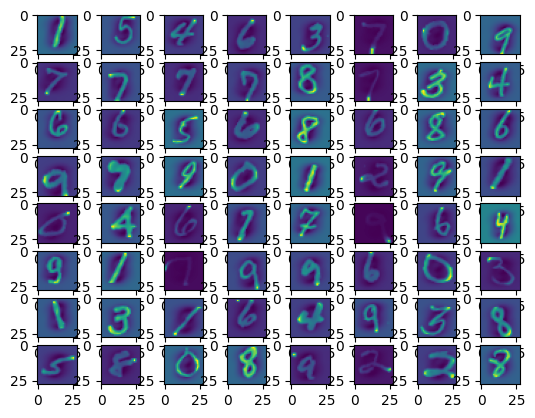

In [17]:
img_iter = datagen.flow(X_train_scaled, y_train, batch_size=batch_size)

x, y = next(img_iter)
fig, ax = plt.subplots(nrows=int(batch_size/8), ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [18]:
datagen.fit(X_train_scaled)

In [19]:
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1, mode='auto')
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
filepath = "my_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq=2)


In [20]:
callbacks = [time_callback, checkpoint, es, lr]

In [21]:
# # Definir le modèle CNN
# model = Sequential()
# model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu", 
#                  input_shape=(28, 28, 1)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# model.add(Flatten())
# model.add(Dense(units=512, activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(units=10, activation="softmax"))

In [22]:
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# # Train the model
# val_data = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(batch_size).repeat()
# history = model.fit(img_iter,
#           epochs=100,
#           steps_per_epoch=len(X_train_scaled)//batch_size,
#           validation_steps=len(X_val_scaled)//batch_size,
#           validation_data=val_data,
#           callbacks=callbacks)

In [24]:
# Creer le modele
def create_model(do_rate, learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding="same", activation="relu", 
                     input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(tf.keras.layers.Dropout(do_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512, activation="relu"))
    model.add(tf.keras.layers.Dropout(do_rate))
    model.add(tf.keras.layers.Dense(units=10, activation="softmax"))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Creer le classifier
keras_classifier = KerasClassifier(model=create_model)

# Definir les hyperparametres à tester
param_grid = {
    'model__do_rate': [0.25, 0.3],
    'model__learning_rate': [0.001],
    'epochs': [5]                           # Seulement 5 epochs par manque de temps et pour tester
}

# Lancer la grid search
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid_search.fit(X_train_scaled, y_train, callbacks=callbacks, validation_data=(X_val_scaled, y_val), verbose=2)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# Print the best parameters and score
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

Best Parameters:  {'batch_size': 32, 'do_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001}
Best Score:  0.9906547466913859


In [ ]:
results = pd.DataFrame(grid_result.cv_results_)

In [ ]:
# Print the values of the model.history.history dictionary
print(history)

NameError: name 'history' is not defined

In [ ]:
# Extract the values of loss and accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [ ]:
print(loss)

[0.3140169680118561, 0.11457649618387222, 0.08528837561607361, 0.0750545784831047, 0.06662412732839584, 0.05889376997947693, 0.05839338153600693, 0.05214357748627663, 0.05094253644347191, 0.04819320887327194, 0.04683176428079605, 0.04483924061059952, 0.04325815290212631, 0.039275284856557846, 0.04083037003874779, 0.038304008543491364, 0.03557265177369118, 0.036762598901987076, 0.034993503242731094, 0.0368058867752552, 0.032566796988248825, 0.031312037259340286, 0.030793795362114906, 0.03098422847688198, 0.03082345426082611, 0.028465013951063156, 0.02719743549823761, 0.027863245457410812, 0.02744857780635357, 0.02598992921411991, 0.024237213656306267, 0.024989044293761253, 0.025951916351914406, 0.02282791957259178, 0.022287338972091675, 0.024270862340927124, 0.024171316996216774, 0.023880518972873688, 0.02188246324658394, 0.02129608578979969, 0.022790132090449333, 0.0192168690264225, 0.02132066898047924, 0.018956895917654037, 0.01917378045618534, 0.021743347868323326, 0.0214858166873455

In [ ]:
print(val_loss)

[0.31663885712623596, 0.13365469872951508, 0.07524434477090836, 0.05597690865397453, 0.04600230231881142, 0.051186129450798035, 0.04612378403544426, 0.06780589371919632, 0.04244280606508255, 0.03389004245400429, 0.048781126737594604, 0.03747996315360069, 0.04410867765545845, 0.03520992025732994, 0.03960927948355675, 0.0424790121614933, 0.04455404728651047, 0.031170684844255447, 0.028547530993819237, 0.04453099146485329, 0.028843943029642105, 0.034924570471048355, 0.031861208379268646, 0.04093501344323158, 0.03737480193376541, 0.03544766828417778, 0.05890977755188942, 0.04015268757939339, 0.05000308156013489, 0.05289115756750107, 0.02968265861272812, 0.03328150510787964, 0.035944387316703796, 0.03720366954803467, 0.049110956490039825, 0.04928738996386528, 0.05712687596678734, 0.02288898266851902, 0.03371064364910126, 0.02280612662434578, 0.027813995257019997, 0.0269935242831707, 0.025256996974349022, 0.026111580431461334, 0.0332556813955307, 0.02294980175793171, 0.030275801196694374, 0.

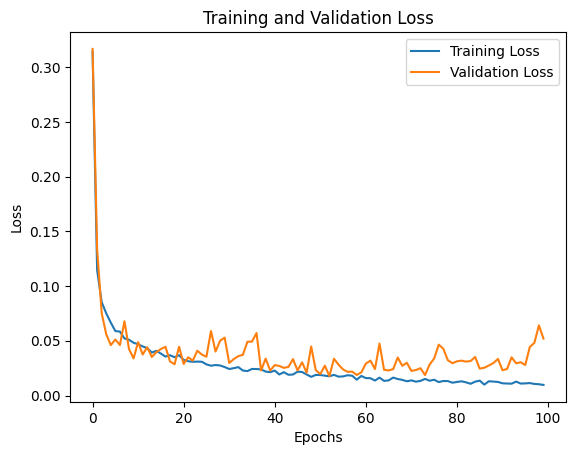

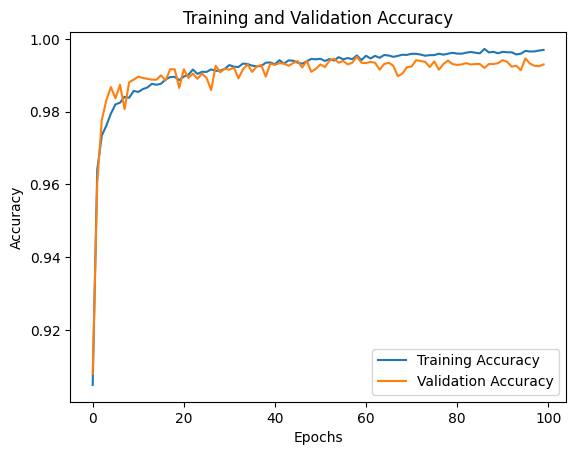

In [ ]:
# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test_scaled)

875/875 [==============================] - 4s 4ms/step


In [ ]:
# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
# Plot a random sample of images with their predicted labels
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

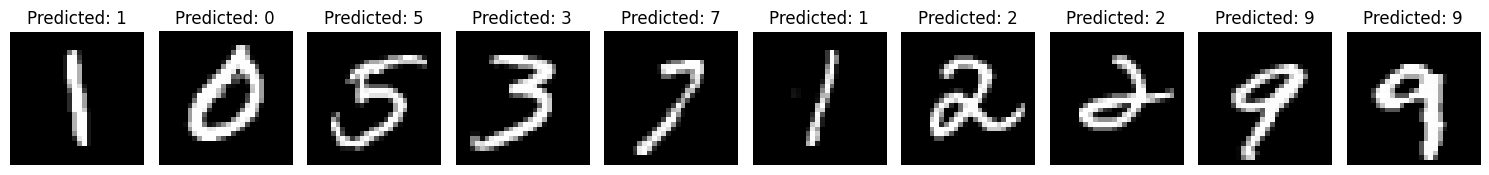

In [ ]:
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image = X_test[idx]
    label = predicted_labels[idx]
    
    axes[i].imshow(image.reshape(28,28), cmap='gray')
    axes[i].set_title(f'Predicted: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()